## **Импорт библиотек**

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *
from fastai import *
import fastai
from fastai.callbacks.hooks import *

import matplotlib.pyplot as plt

## **Описание вспомогательных функций**

In [3]:
def display_image_mask_grid(n):
  images_list = []
  for i in range(n):
    images_list.append(random.choice(os.listdir(img_path)))
  for idx, image in enumerate(images_list):  
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    img = plt.imread(str(img_path/image))
    axs[0].imshow(img)
    msk = plt.imread(str(mask_path/image))
    axs[1].imshow(msk, cmap='gray')    
    plt.grid(False)
    plt.show() 

In [4]:
class MaskSegmentationLabelList(SegmentationLabelList):
    def open(self, fn): 
      return open_mask(fn, div=True)

class MaskSegmentationItemList(ImageList):
    _label_cls,_square_show_res = MaskSegmentationLabelList, False

In [5]:
def dice_loss(input, target):
    smooth = 1.
    input = input[:,1,None].sigmoid()
    iflat = input.contiguous().view(-1).float()
    tflat = target.view(-1).float()
    intersection = (iflat * tflat).sum()
    return (1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth)))

def combo_loss(pred, targ):
    bce_loss = CrossEntropyFlat(axis=1)
    return bce_loss(pred,targ) + dice_loss(pred,targ)

## **Указание пути и проверка исходных данных**

In [6]:
from fastai.vision import *
#src_path = Path('/content/AerialImageDataset/')
root_path = Path('/content/drive/My Drive/Netology/Datasets/InriaDataset/')

#image_hr_path = src_path/'train/images'
#mask_hr_path = src_path/'train/gt'
#test_hr_path = src_path/'test/images'

image_lr_path = root_path/'train'
test_lr_path = root_path/'test'
train_mask_lr_path = root_path/'masks'

#hr_images = ImageList.from_folder(image_hr_path)
#hr_masks = ImageList.from_folder(mask_hr_path)
#hr_tests = ImageList.from_folder(test_hr_path)

In [7]:
images = get_image_files(image_lr_path)
masks = get_image_files(train_mask_lr_path)
len(images),len(masks)

(180, 180)

In [9]:
root_dir = Path('/content/drive/My Drive/Netology/Datasets/InriaDataset')
train_path = root_dir/'train'
test_path = root_dir/'test'
mask_path = root_dir/'masks'
img_path = train_path
img_path, mask_path

(PosixPath('/content/drive/My Drive/Netology/Datasets/InriaDataset/train'),
 PosixPath('/content/drive/My Drive/Netology/Datasets/InriaDataset/masks'))

In [12]:
images = get_image_files(img_path)
masks = get_image_files(mask_path)
len(images),len(masks)

(180, 180)

In [10]:
# Check if all images are present in the folders 
images = get_image_files(img_path)
masks = get_image_files(mask_path)
len(images),len(masks)

(180, 180)

In [11]:
# Size of each image and its mask
image = open_image(images[0])
img_size = np.array(image.shape[1:])
print(image.shape)

mask = open_mask(masks[0], div=True)
print(mask.shape)
mask_size = np.array(mask.shape[1:])
print(mask.data)

np.unique(np.array(mask.data))

torch.Size([3, 512, 512])
torch.Size([1, 512, 512])
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])


array([0, 1])

In [15]:
get_mask_file = lambda x: mask_path/f'{x.stem.split("/")[-1]}.tif'
img = images[0]
img, get_mask_file(img)

(PosixPath('/content/drive/My Drive/Netology/Datasets/InriaDataset/train/austin24.tif'),
 PosixPath('/content/drive/My Drive/Netology/Datasets/InriaDataset/masks/austin24.tif'))

## **Визуализация данных**

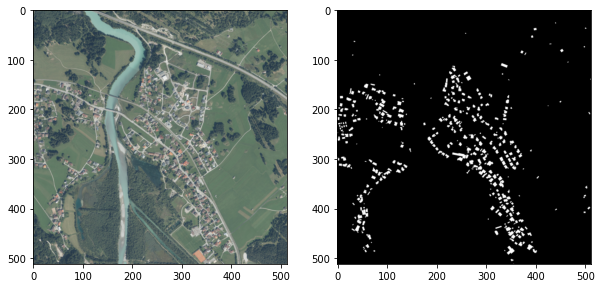

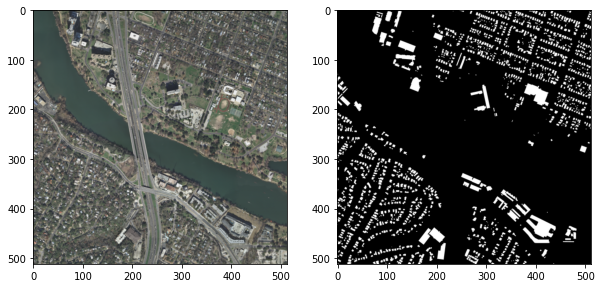

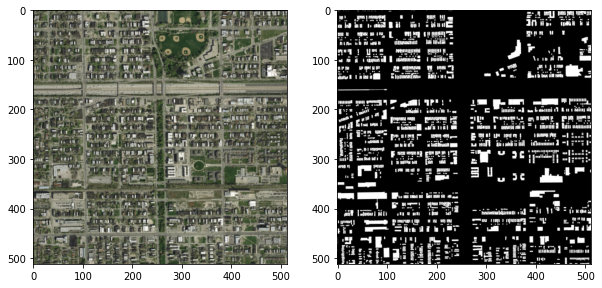

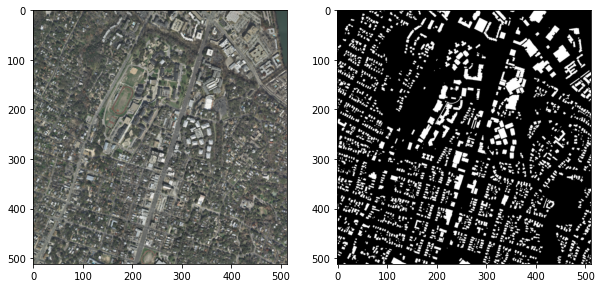

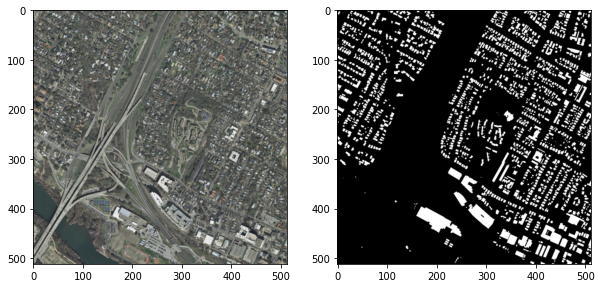

In [16]:
display_image_mask_grid(5)

### **Обучение модели**

In [17]:
# Parameters
codes = np.array(['NotBuilding','Building'])
src_size = np.array(mask.shape[1:])
size = src_size
bs = 4

In [18]:
src = MaskSegmentationItemList.from_folder(train_path).split_by_fname_file(root_dir/'valid.txt').label_from_func(get_mask_file, classes=codes)
tfms = get_transforms(flip_vert=True, max_warp=0, max_zoom=1.2, max_lighting=0.3)
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats)
)

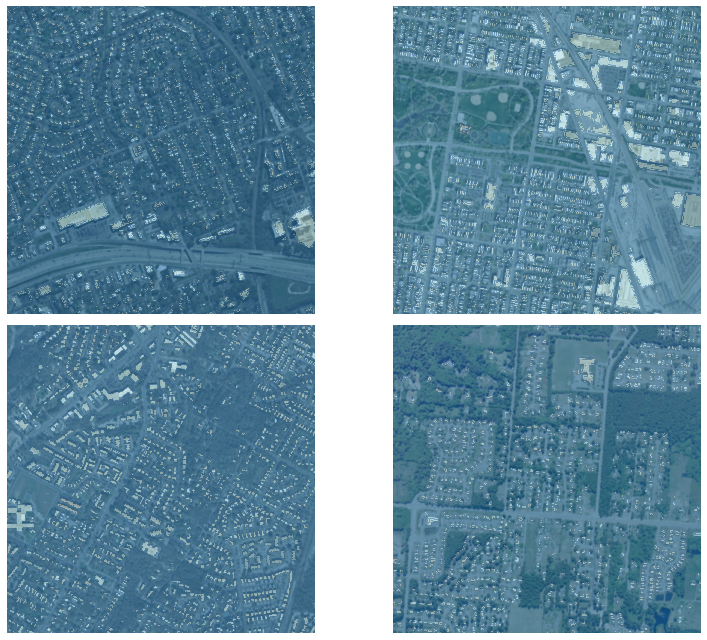

In [19]:
data.show_batch(rows=3, figsize=(12,9))

In [20]:
len(data.train_ds.x.items), len(data.train_ds.y.items),len(data.valid_ds.x.items), len(data.valid_ds.y.items)

(155, 155, 25, 25)

In [21]:
# Labels
data.classes

array(['NotBuilding', 'Building'], dtype='<U11')

## **Описание метрики**

In [22]:
metrics = [dice_loss, accuracy_thresh, dice]
learn = unet_learner(data, models.resnet34, metrics=metrics)
learn.metrics = metrics
learn.loss_func = combo_loss

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


## **Обучение модели**

In [23]:
#learn.freeze()
#learn.lr_find()
#learn.recorder.plot()

epoch,train_loss,valid_loss,dice_loss,accuracy_thresh,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: ignored

In [25]:
lr = 1e-03
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,dice_loss,accuracy_thresh,dice,time
0,1.159422,1.033143,0.809389,0.488961,0.051732,34:31
1,1.039513,0.926465,0.697608,0.791613,0.073749,34:13
2,0.977177,0.803781,0.621591,0.894539,0.082567,34:14
3,0.897915,0.785624,0.614759,0.926405,0.125664,34:15
4,0.845268,0.765548,0.600122,0.864665,0.253213,34:23
5,0.827430,0.748302,0.585218,0.885340,0.193818,34:29
6,0.794719,0.731464,0.567959,0.900909,0.312742,34:29
7,0.765110,0.736207,0.577373,0.882038,0.260404,34:26
8,0.747114,0.713584,0.558035,0.899801,0.239428,34:23
9,0.746272,0.729104,0.570070,0.888043,0.237721,34:28


In [26]:
learn.save("stage-1-rn34-512")

In [27]:
learn.fit_one_cycle(10, slice(lr))


epoch,train_loss,valid_loss,dice_loss,accuracy_thresh,dice,time
0,0.740107,0.710501,0.556703,0.903946,0.156446,34:23
1,0.752444,0.747575,0.550686,0.925398,0.043345,34:21
2,0.761213,0.745495,0.567290,0.893519,0.282081,34:27
3,0.774690,0.758893,0.586462,0.898224,0.120303,34:25
4,0.759283,0.726030,0.569986,0.881266,0.187236,34:15
5,0.749785,0.703111,0.549867,0.901507,0.151387,34:15
6,0.730387,0.685111,0.535118,0.904074,0.207428,34:18
7,0.717214,0.676737,0.530275,0.906511,0.277088,34:22
8,0.703901,0.689190,0.538408,0.901184,0.254028,34:21
9,0.694963,0.689327,0.539643,0.900274,0.236599,34:25


In [28]:
learn.save("stage-1-rn34-512")

In [29]:
learn = learn.load("stage-1-rn34-512")

In [30]:
outputs = learn.pred_batch(ds_type=DatasetType.Valid)
outputs.shape

torch.Size([4, 2, 512, 512])

In [1]:
for i in range(bs):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

    data.valid_ds.x[i].show(ax=ax1)
    ax1.set_title('Prediction')
    ax1.imshow(alpha=0.6)
    
    ax2.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax2)
    data.valid_ds.y[i].show(ax=ax2, alpha=0.6)
    plt.show()

NameError: ignored

## **Проверка на тестовых данных**

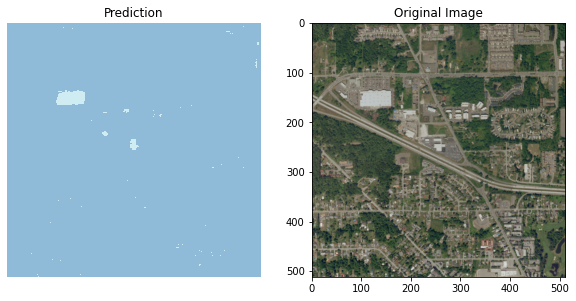

In [35]:
img = open_image(test_path/'bellingham20.tif')
prediction = learn.predict(img)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.set_title('Prediction')
prediction[0].show(figsize=(5,5), ax=ax1)
ax2.set_title('Original Image')
img = plt.imread(str(test_path/'bellingham20.tif'))
ax2.imshow(img)